# Principal Component Pursuit

## Prepare Dataset

Extract images from _PNNL Parking Lot 1 dataset_ (video file).

In [1]:
from   PIL import Image
from   IPython.display import display
import numpy as np
import cv2
import os

width  = 960
height = 540
frames = 250
skip   = 1000 / frames

def save_all_frames(video_path, dir_path, basename, ext='png'):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return

    os.makedirs(dir_path, exist_ok=True)
    base_path = os.path.join(dir_path, basename)

    digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))

    n = 0
    while n < skip * frames:
        ret, frame = cap.read()
        if ret:
            if n % skip == 0:
                small_frame = cv2.resize(frame, (0,0), fx=0.5, fy=0.5)
                file_name   = '{}_{}.{}'.format(base_path, str(int(n/skip+1)).zfill(digit), ext)
                cv2.imwrite(file_name, small_frame)
        else:
            return
        n += 1

save_all_frames('../data/PNNL_Parking_LOT.avi', '../data/frames/', 'frame')
print('frames saved')

frames saved


## Load Images into Matrix

In [2]:
def display_frame(A, frame):
    img   = np.uint8(np.reshape(A[:, frame], (height, width)))
    image = Image.fromarray(img, 'L')
    image = image.resize((320,180))
    display(image)


def save_frame(A, frame, filename):
    img   = np.uint8(np.reshape(A[:, frame], (height, width)))
    image = Image.fromarray(img, 'L')
    image.save(filename)


def get_frame_num(frame):
    if frame < 9:
        return '00' + str(frame + 1)
    elif frame < 99:
        return '0' + str(frame + 1)
    elif frame < 999:
        return  str(frame + 1)
    else:
        assert False


def save_sample(M, L, S, frame=100):
    file_name = '../results/sample_frame_' + str(frame)
    save_frame(M, frame, file_name + '_M.png')
    save_frame(L, frame, file_name + '_L.png')
    save_frame(0.5 * (S + 255), frame, file_name + '_S.png')


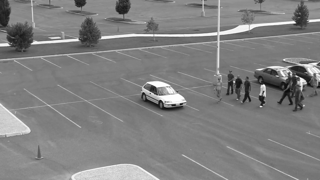

M.shape =  (518400, 250)


In [3]:
M = np.zeros((width * height, frames))
for k in range(frames):
    image   = Image.open('../data/frames/frame_' + get_frame_num(k) + '.png').convert('L')
    img     = np.array(image)
    M[:, k] = np.reshape(img, (height * width))

display_frame(M, 50)
print("M.shape = ", M.shape)

# Execute Solvers

In [4]:
from scipy.sparse.linalg import svds
import scipy as sp


def shrink(x, alpha):
    return np.sign(x) * np.maximum(np.abs(x) - alpha, 0)


def svt(A, alpha, num_s_vals=100, use_svd=True, use_sparse=False):
    U, S, V = np.linalg.svd(A, full_matrices=False)
    S = np.sign(S) * np.maximum(np.abs(S) - alpha, 0)
    return (U * S) @ V


def ball_proj(X, eps):
    ''' Project onto ball w.r.t. Frobenius norm
    '''
    norm = np.linalg.norm(X, ord='fro')
    if norm > eps:
        return X * eps / norm
    else:
        return X

def update_stats(viol, obj, res, XL, XL_p, XS, XS_p, M, lambd, eps, k, verbose=False):
    res_k   = np.linalg.norm(XL - XL_p, ord='fro') ** 2.0
    res_k  += np.linalg.norm(XS - XS_p, ord='fro') ** 2.0
    res_k   = (res_k ** 0.5)
    res[k]  = res_k / np.linalg.norm(M, ord='fro')
    obj[k]  = np.linalg.norm(XL, ord='nuc') + lambd * np.linalg.norm(XS, ord=1) 
    viol[k] = max(0.0, np.linalg.norm(XL + XS - M, ord='fro') - eps) / eps
    
    if verbose:
        msg     = '%0.5d: obj = %0.4e, |X - X_p| = %0.5e  max(0, |XL + XS - M|_F - eps) = %0.5e'
        print(msg % (k, obj[k], res[k], viol[k]))
        display_frame(XL, k % frames)
        display_frame(0.5 * (XS + 255.0), k % frames)  

    return viol, obj, res

In [5]:
def PP(M, lambd, eps, alpha=3.0e4, iters=30, verbose=False):
    ''' Execute Proximal Projection
    '''
    # Initializations
    res    = np.zeros(iters)
    viol   = np.zeros(iters)
    obj    = np.zeros(iters)
    ZL     = M.copy()
    ZS     = np.zeros(M.shape)
    XL     = M.copy()
    XS     = np.zeros(M.shape)

    for k in range(iters):
        XL_p    = XL.copy()
        XS_p    = XS.copy() 
        ZL      = ZL + svt(2 * XL - ZL, alpha) - XL
        ZS      = ZS + shrink(2 * XS - ZS, lambd * alpha) - XS
        AW_norm = np.linalg.norm(ZL + ZS - M, ord='fro')
        mu      = np.maximum(0, (AW_norm - eps) / (2 * AW_norm))
        XL      = ZL - mu * (ZL + ZS - M)
        XS      = ZS - mu * (ZL + ZS - M)        

        viol, obj, res = update_stats(viol, obj, res, XL, XL_p, XS, XS_p, M, lambd, eps, k, verbose=verbose)

    return XL, XS, res, viol, obj


def PG(M, lambd, eps, alpha=1.0e3, iters=30, verbose=False):
    ''' Execute Proximal Gradient 

        Magic numbers:
            too small  - 1e3
            too big    - 1e5
            just right - 8e3 
    '''
    res    = np.zeros(iters)
    viol   = np.zeros(iters)
    obj    = np.zeros(iters) 
    XL     = M.copy()
    XS     = np.zeros(M.shape)

    for k in range(iters):
        XL_p = XL.copy()
        XS_p = XS.copy()
        XL   = svt(M - XS, alpha)
        XS   = shrink(M - XL, lambd * alpha)

        viol, obj, res = update_stats(viol, obj, res, XL, XL_p, XS, XS_p, M, lambd, eps, k, verbose=verbose)

    return XL, XS, res, viol, obj


def get_root(A, lambd, mu, eps, tol=1.0e-8):
    ''' Compute roots for PGS
    '''
    if np.linalg.norm(A, ord='fro') <= eps:
        return 0.0
    else:
        t_lo     = 0.0 
        t_hi     = min(A.shape[0] * A.shape[1] * lambd * eps, np.abs(np.linalg.norm(A, ord='fro') - eps) / (mu * eps))
        root_est = np.inf
        tol     *= eps
    
        while np.abs(root_est) > tol:
            t        = 0.5 * (t_lo + t_hi)
            root_est = np.linalg.norm(np.minimum(lambd / t * np.ones(A.shape), A / (1.0 + mu * t)), ord='fro') - eps
            if root_est < 0.0:
                t_hi = t
            else:
                t_lo = t
        return t    


def SPG(M, lambd, eps, mu=1.73755e5, iters=30, verbose=False):
    ''' Execute Proximal Gradient on Smoothed Problem

        opt_est = 1.73755e6
    '''
    res    = np.zeros(iters)
    viol   = np.zeros(iters)
    obj    = np.zeros(iters) 
    XL     = M.copy()
    XS     = np.zeros(M.shape)
    mu    /= min(M.shape[0], M.shape[1])
    print('mu = ', mu)

    for k in range(iters):
        XL_p  = XL.copy()
        XS_p  = XS.copy()
        Q     = svt(XL, mu)
        theta = get_root(np.abs(M-Q), lambd, mu, eps)
        if theta > 0:
            XS    = shrink(M - Q, lambd * (1.0 + mu * theta) / theta)
        else:
            XS = np.zeros(XS.shape)
        XL    = (mu * theta * (M - XS) + Q) / (1.0 + mu * theta) 

        viol, obj, res = update_stats(viol, obj, res, XL, XL_p, XS, XS_p, M, lambd, eps, k, verbose=verbose)

    return XL, XS, res, viol, obj


def VASALM(M, lambd, eps, alpha=1.0e-5, eta=3.0, iters=30, verbose=False):
    ''' Execute Variant of Alternative Splitting Augmented Lagrangian Method
    ''' 
    res    = np.zeros(iters)
    viol   = np.zeros(iters)
    obj    = np.zeros(iters)
    XL     = M.copy()
    XS     = np.zeros(M.shape)
    Lambd  = np.zeros(M.shape)

    for k in range(iters):
        XL_p    = XL.copy()
        XS_p    = XS.copy()
        Lambd_p = Lambd.copy() 
        N       = ball_proj(Lambd / alpha + M - XS - XL, eps)
        Lambd   = Lambd - alpha * (XL + XS + N - M)
        XS      = shrink(XS + Lambd / (alpha * eta), lambd / (alpha * eta))
        XL      = svt(XL + Lambd / (alpha * eta), 1.0 / (alpha * eta))
        Lambd   = Lambd + alpha * (XL_p - XL) + alpha * (XS_p - XS)

        viol, obj, res = update_stats(viol, obj, res, XL, XL_p, XS, XS_p, M, lambd, eps, k, verbose=verbose)

    return XL, XS, res, viol, obj


# Execute Experiment

In [ ]:
iters  = 30
lambd  = (M.shape[0]) ** -0.5
eps    = 0.10 * (M.size ** 0.5) * np.std(M) 
print('eps/|M|_F  = ', eps / np.linalg.norm(M, ord='fro'))

print('Executing Proximal Projection')
L_pp, S_pp, res_pp, viol_pp, obj_pp = PP(M, lambd, eps, iters=iters, verbose=True)
print('Executing Variant Alternating Splitting Augmented Lagrangian Method')
_, _, res_vasalm, viol_vasalm, obj_vasalm = VASALM(M, lambd, eps, iters=iters, verbose=True)
print('Executing Smoothed Proximal Gradient')
_, _, res_spg, viol_spg, obj_spg = SPG(M, lambd, eps, iters=iters, verbose=True)

## Plot Results

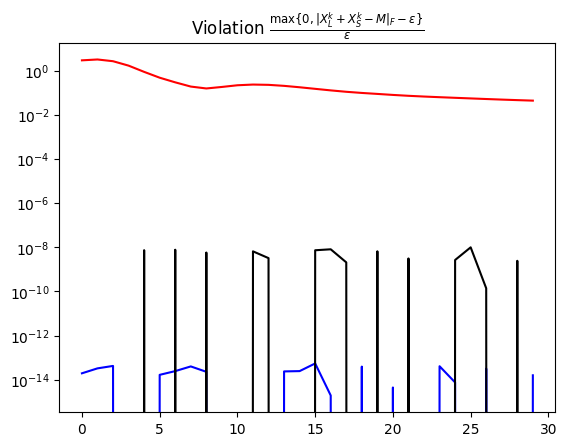

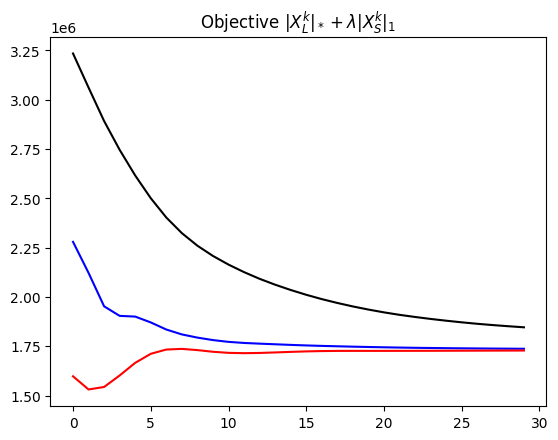

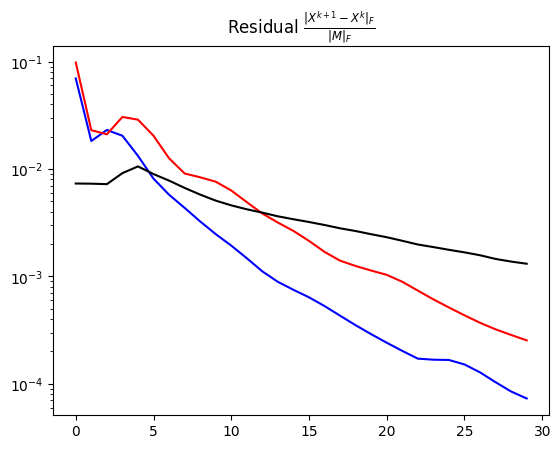

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.title('Violation $\\frac{\\max\\{0,|X^k_L + X^k_S - M|_F- \\varepsilon\\}}{\\varepsilon}$')
plt.plot(viol_pp,     color='b')
plt.plot(viol_vasalm, color='r') 
plt.plot(viol_spg,    color='k')
plt.yscale('log')
plt.show()

fig, ax = plt.subplots()
plt.title('Objective $|X^k_L|_* + \\lambda |X^k_S|_1$')
plt.plot(obj_pp,     color='b')
plt.plot(obj_vasalm, color='r') 
plt.plot(obj_spg,    color='k')
plt.show()
    
fig, ax = plt.subplots()
plt.title('Residual $\\frac{|X^{k+1}-X^k|_F}{|M|_F}$')
plt.plot(res_pp,     color='b')
plt.plot(res_vasalm, color='r') 
plt.plot(res_spg,    color='k')
plt.yscale('log')
plt.show()

## Save Results

In [14]:
save_sample(M, L_pp, S_pp, frame=85)  

filename = '../results/spcp-obj-plots.csv'
with open(filename, 'w') as csv_file:
    for k in range(len(obj_pp)):
        csv_file.write('%0.5e,%0.5e,%0.5e\n' % (obj_pp[k], obj_vasalm[k],
                                                obj_spg[k]))
filename = '../results/spcp-res-plots.csv'
with open(filename, 'w') as csv_file:
    for k in range(len(res_pp)):
        csv_file.write('%0.5e,%0.5e,%0.5e\n' % (res_pp[k], res_vasalm[k],
                                                res_spg[k]))
filename = '../results/spcp-viol-plots.csv'
with open(filename, 'w') as csv_file:
    for k in range(len(viol_pp)):
        csv_file.write('%0.5e,%0.5e,%0.5e\n' % (viol_pp[k], viol_vasalm[k],
                                                viol_spg[k]))